# AIT 526 – Project: Understanding Recipe Reviews with Sentiment Analysis



### 1. Problem Statement

In this project, I aim to analyze user reviews of recipes to understand user sentiments, identify common discussion topics, and detect potentially fake reviews. I use Natural Language Processing (NLP) and Machine Learning techniques such as sentiment analysis (VADER and TextBlob), topic modeling (LDA), and anomaly detection (One-Class SVM).

---

### 2. Dataset Information

- **Dataset Source:** [UCI Machine Learning Repository - Recipe Reviews and User Feedback Dataset](https://archive.ics.uci.edu/dataset/911/recipe+reviews+and+user+feedback+dataset)
- **Columns:** Review Text, Rating, Recipe Name, User ID, Timestamp

---

### 3. Working of the Project

The project is designed to systematically process and analyze recipe review texts to extract meaningful insights through multiple stages:

- **Text Preprocessing:**  
  Raw user reviews are cleaned by removing noise such as HTML tags, punctuation, and stopwords. Words are tokenized and lemmatized to their base forms to ensure consistency.

- **Sentiment Analysis:**  
  Two sentiment analysis models, VADER and TextBlob, are applied independently. The sentiment scores from both models are averaged to provide a more balanced and robust sentiment prediction for each review.

- **Sentiment Labeling:**  
  Each review is categorized into Positive, Neutral, or Negative based on the computed sentiment score.

- **Topic Modeling:**  
  Using Latent Dirichlet Allocation (LDA), major discussion themes are extracted from the review texts, helping to understand common concerns or highlights such as taste, preparation time, or ingredient substitutions.

- **Fake Review Detection:**  
  A One-Class Support Vector Machine (SVM) model is trained on normal review patterns. It flags suspicious reviews that deviate significantly, which may indicate fake or low-quality feedback.

- **Visualization:**  
  Key findings, such as sentiment distributions, word clouds, and fake review proportions, are visualized to present the results in an intuitive and accessible manner.

- **XGBoost Classification with SMOTE:**
  Additional features are extracted from the reviews and used to train an XGBoost classifier. Class imbalance is handled using SMOTE, and the model is evaluated on its ability to detect fake reviews.

- **Final WordCloud and Export:**
  A final word cloud is generated from authentic reviews, and the processed dataset is exported for further analysis or sharing.

##### This modular workflow allows the system to not only understand general user sentiment but also to enhance the integrity of review platforms by identifying unreliable feedback.
---

### 4. Algorithm Breakdown (Step-by-Step)

1. **Import Necessary Libraries**  
   - Load all required Python libraries for data processing, NLP, machine learning, and visualization.

2. **Download NLTK Resources**  
   - Download tokenizers, stopwords, and lemmatizer datasets required for text preprocessing.

3. **Load Dataset**  
   - Read the Recipe Reviews dataset (CSV format) into a DataFrame.  
   - Validate the column names and prepare for text processing.

4. **Text Preprocessing**  
   - Remove unwanted characters (HTML tags, URLs, punctuation).
   - Convert text to lowercase, tokenize words, remove stopwords, and lemmatize tokens.
   - Store the cleaned review text.

5. **Sentiment Analysis**  
   - Apply **VADER** and **TextBlob** to calculate sentiment scores for each cleaned review.
   - Average the two sentiment scores for greater reliability.
   
6. **Sentiment Visualization**  
   - Plot a bar chart showing the distribution of sentiment labels across all reviews.

7. **Correlation Heatmap**:
   - Visualize the correlation between VADER, TextBlob, and averaged sentiment scores.

8. **Scatterplot Visualization**:
   - Display a scatterplot to show the relationship between VADER and TextBlob sentiment scores.

9. **Random Review Examples**:
    - Print random examples of Positive, Neutral, and Negative reviews.

10. **Word Cloud Generation**  
    - Create separate word clouds for Positive, Neutral, and Negative reviews to visualize the most common words.

11. **Topic Modeling with LDA**  
    - Transform text into a bag-of-words representation.
    - Use Latent Dirichlet Allocation (LDA) to discover hidden topics in the review corpus.
    - Display top words for each discovered topic.
      
12. **Topic Assignment Using LDA and NMF Models**
    - Assign the most probable topic to each review using the LDA model based on topic probability.
    - Train a Non-negative Matrix Factorization (NMF) model and display top words for each NMF topic.
    - Assign NMF topic labels to reviews for comparison with LDA results.

14. **Visualization of Topic Distribution and Review Length Analysis**
    - Plot a bar chart showing the number of reviews per NMF topic to understand topic popularity.
    - Create a boxplot to analyze the variation in review lengths across different sentiment categories (Positive, Neutral, Negative)

16. **Regression Analysis Between Review Length and Thumbs Up**
    - Plot a regression graph to observe the relationship between the length of a review and the number of 'Thumbs Up' received.
    - Analyze if longer reviews are associated with more positive engagement.
      
17. **Fake Review Detection using One-Class SVM**  
    - Use sentiment features (VADER and TextBlob scores) to train a One-Class SVM model.
    - Predict and label reviews as **Normal** or **Fake** based on anomaly detection.
    - Plot a pie chart showing the proportion of flagged fake reviews versus normal reviews.
      
18. **Sentiment Distribution in Real vs Fake Reviews**
    - Generate a stacked bar chart to compare how sentiment labels (Positive, Neutral, Negative) are distributed across Normal and Fake reviews.
      
19. **XGBoost Classification with SMOTE**
    - Extract custom features and handle class imbalance with SMOTE.
    - Train an XGBoost classifier to distinguish fake reviews and evaluate its performance using accuracy, classification metrics, and a confusion matrix.
      
20. **WordCloud for Real Reviews and Export**
    - Visualize frequently used terms in authentic reviews and export the final processed dataset to CSV format.

---

### 5. Step-by-Step Implementation

### Step 1: Import Libraries

In [5]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from gensim import corpora
from gensim.models import LdaModel
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE


### Step 2: Load the Dataset

In [7]:
try:
    file_path = r"C:/Users/ABHIRAM/Downloads/Recipe Reviews and User Feedback Dataset.csv"
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("File not found. Please check the path and try again.")

Dataset loaded successfully!


### Step 3: Preprocessing


In [9]:
# Check if text column exists and rename for consistency
if 'text' in df.columns:
    df.rename(columns={'text': 'Review_Text'}, inplace=True)
elif 'Review_Text' not in df.columns:
    raise ValueError("The dataset does not contain a 'text' or 'Review_Text' column.")

### Step 4: Text Processing

In [11]:
# Initialize lemmatizer and stopwords set
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
# Define preprocessing function: clean, lowercase, tokenize, remove stopwords, lemmatize
def preprocess_text(text):
    if pd.isnull(text):
        return ""
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word.isalpha()]
    return ' '.join(tokens)
# Apply preprocessing
df['cleaned_text'] = df['Review_Text'].apply(preprocess_text)
# Drop empty cleaned text rows
df = df[df['cleaned_text'].str.strip() != ""]

### Step 5: Sentiment Analysis (VADER + TextBlob)

In [13]:
# Initialize sentiment analyzer
analyzer = SentimentIntensityAnalyzer()
# Calculate compound score from VADER
# Calculate polarity score from TextBlob
df['vader_sentiment'] = df['cleaned_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df['textblob_sentiment'] = df['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
# Average the two scores
df['avg_sentiment'] = (df['vader_sentiment'] + df['textblob_sentiment']) / 2
# Sentiment Labeling
def get_sentiment_label(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'
df['sentiment_label'] = df['avg_sentiment'].apply(get_sentiment_label)

### Step 6: Sentiment Distribution Visualization


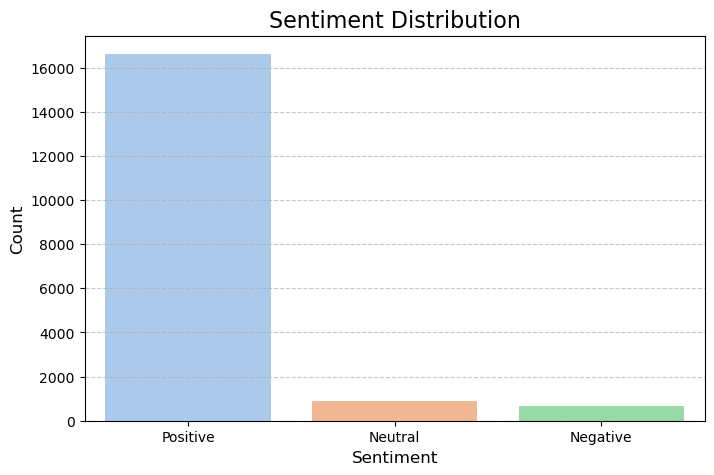

In [15]:
# Plot sentiment label distribution with seaborn
plt.figure(figsize=(8,5))
sns.countplot(x='sentiment_label', hue='sentiment_label', data=df, palette='pastel', legend=False)
plt.title("Sentiment Distribution", fontsize=16)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Step 7: Heatmap of Sentiment Score Correlation


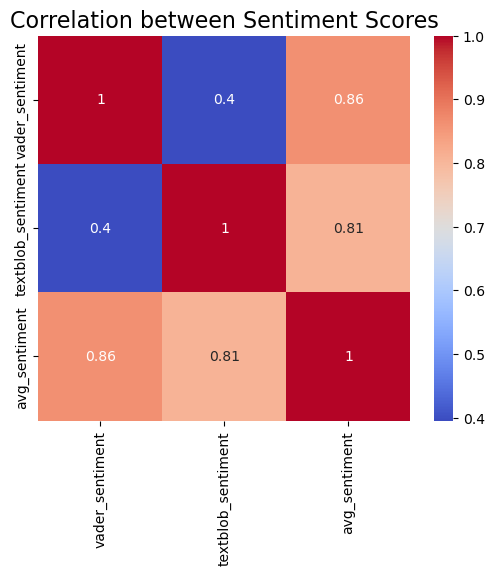

In [17]:
corr = df[['vader_sentiment', 'textblob_sentiment', 'avg_sentiment']].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation between Sentiment Scores", fontsize=16)
plt.show()

### Step 8: Scatterplot of VADER vs TextBlob Scores


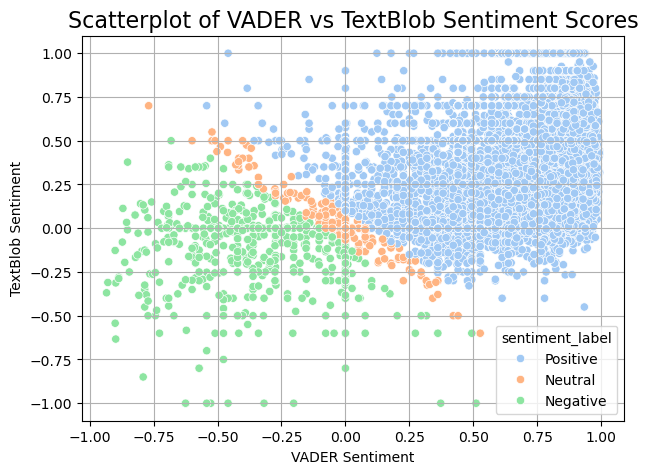

In [19]:
plt.figure(figsize=(7,5))
sns.scatterplot(x='vader_sentiment', y='textblob_sentiment', data=df, hue='sentiment_label', palette='pastel')
plt.title("Scatterplot of VADER vs TextBlob Sentiment Scores", fontsize=16)
plt.xlabel("VADER Sentiment")
plt.ylabel("TextBlob Sentiment")
plt.grid(True)
plt.show()

### Step 9: Display Random Review Examples


In [21]:
print("Example Positive Review:\n")
print(df[df['sentiment_label'] == 'Positive']['Review_Text'].sample(1).values[0])
print("\nExample Neutral Review:\n")
print(df[df['sentiment_label'] == 'Neutral']['Review_Text'].sample(1).values[0])
print("\nExample Negative Review:\n")
print(df[df['sentiment_label'] == 'Negative']['Review_Text'].sample(1).values[0])

Example Positive Review:

My family absolutely loved this dish and requested that we have it again.

Example Neutral Review:

My go to macaroni salad!

Example Negative Review:

DO NOT BAKE THIS IN AN 8x4 PAN AS DIRECTED. MY BREAD HAS BEEN IN THE OVEN 1 HOUR AND 25 MINUTES AND IT&#39;S STILL GOO IN THE MIDDLE. I&#39;M VERY DISAPPOINTED BECAUSE THE BATTER WAS DELICIOUS AND I&#39;VE USED 3 LEMONS AND A 6 OUNCE CONTAINER OF BLUEBERRIES. WHAT A WASTE.


### Step 10: Word Clouds for Each Sentiment

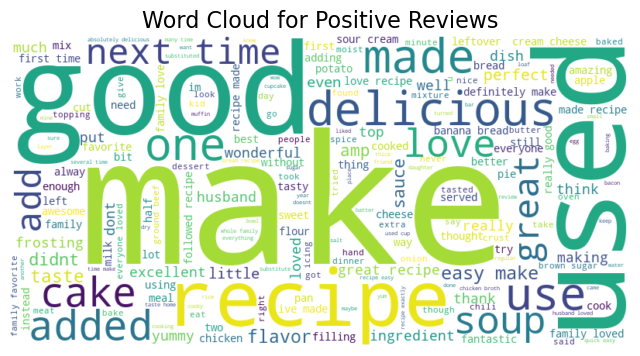

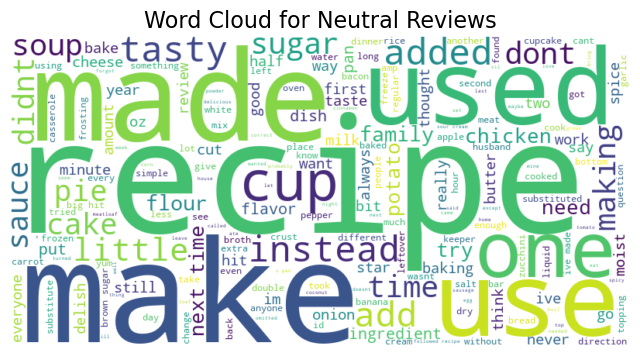

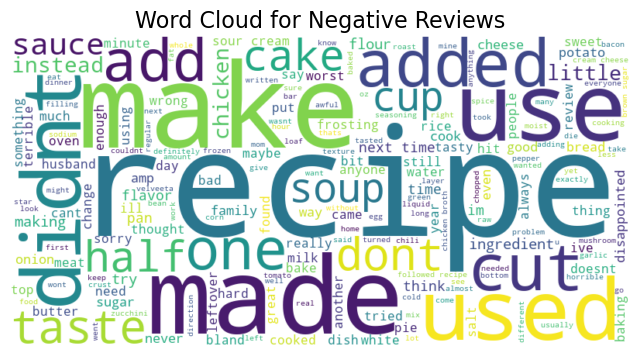

In [23]:
# Generate and display word clouds for Positive, Neutral, and Negative sentiments

for sentiment in ['Positive', 'Neutral', 'Negative']:
    text = ' '.join(df[df['sentiment_label'] == sentiment]['cleaned_text'])
    if text:
        wc = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.figure(figsize=(8,5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for {sentiment} Reviews", fontsize=16)
        plt.show()

### Step 11: Topic Modeling with LDA

In [25]:
# Convert text data to bag-of-words format
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df['cleaned_text'])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)
words = vectorizer.get_feature_names_out()
# Display Top Words for Each Topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx+1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
print("\nTop words in each LDA topic:")
display_topics(lda, vectorizer.get_feature_names_out(), 10)


Top words in each LDA topic:
Topic 1:
added soup add used sauce onion recipe pepper cheese good
Topic 2:
cake recipe bread sugar make used banana cup frosting moist
Topic 3:
pie recipe make apple time used crust potato good use
Topic 4:
recipe make family love time easy loved good delicious great
Topic 5:
used cream chicken recipe instead make use cheese cup delicious


### Step 12: Topic Assignment Using LDA and NMF Models

In [27]:
# Tokenize the cleaned text reviews and prepare the corpus for LDA modeling
tokenized_reviews = [word_tokenize(text) for text in df['cleaned_text']]
tokenized_reviews = [tokens for tokens in tokenized_reviews if len(tokens) > 0]
dictionary = corpora.Dictionary(tokenized_reviews)
corpus = [dictionary.doc2bow(text) for text in tokenized_reviews]
# Build an LDA topic model and assign the most likely topic to each review
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes=10)
topic_assignments = []
for i in range(len(df)):
    if i < len(corpus) and len(corpus[i]) > 0:
        topic = max(lda_model.get_document_topics(corpus[i]), key=lambda x: x[1])[0]
    else:
        topic = -1
    topic_assignments.append(topic)
df['topic'] = topic_assignments
# Build an NMF topic model and assign topics based on text features
from sklearn.decomposition import NMF
nmf = NMF(n_components=5, random_state=42)
nmf.fit(X)
for idx, topic in enumerate(nmf.components_):
    print(f"Topic {idx + 1}: ", [words[i] for i in topic.argsort()[-10:]])
topic_assignments_nmf = nmf.transform(X).argmax(axis=1)
df['nmf_topic'] = topic_assignments_nmf

Topic 1:  ['making', 'ive', 'banana', 'year', 'best', 'family', 'love', 'great', 'bread', 'recipe']
Topic 2:  ['onion', 'good', 'chicken', 'soup', 'cream', 'cheese', 'instead', 'cup', 'added', 'used']
Topic 3:  ['like', 'great', 'love', 'loved', 'definitely', 'family', 'good', 'delicious', 'easy', 'make']
Topic 4:  ['icing', 'mix', 'cup', 'cream', 'pan', 'sugar', 'moist', 'chocolate', 'frosting', 'cake']
Topic 5:  ['little', 'sauce', 'like', 'bread', 'good', 'ive', 'add', 'love', 'use', 'time']


### Step 13: Visualization of Topic Distribution and Review Length Analysis


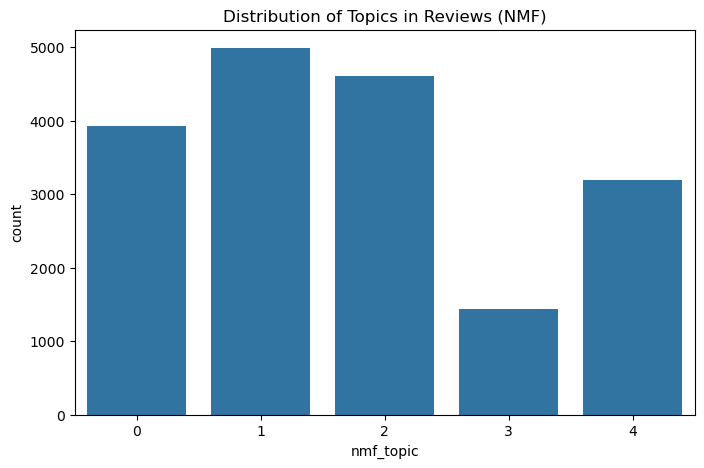

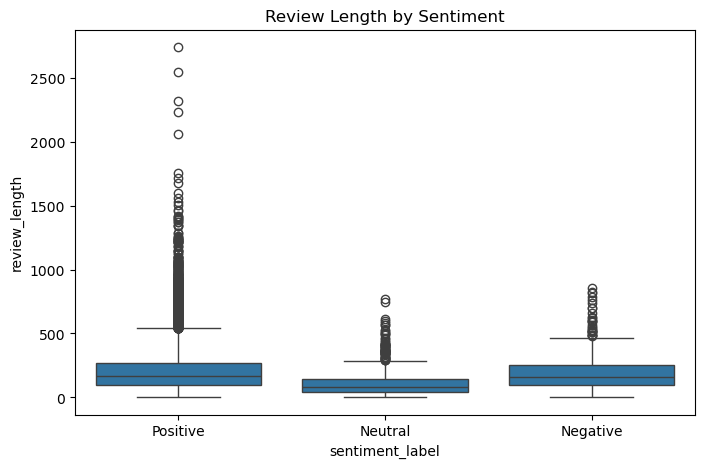

In [29]:
plt.figure(figsize=(8,5))
sns.countplot(x='nmf_topic', data=df)
plt.title("Distribution of Topics in Reviews (NMF)")
plt.show()
df['review_length'] = df['Review_Text'].astype(str).apply(len)
plt.figure(figsize=(8, 5))
sns.boxplot(x='sentiment_label', y='review_length', data=df)
plt.title("Review Length by Sentiment")
plt.show()

### Step 14: Regression Analysis Between Review Length and Thumbs Up


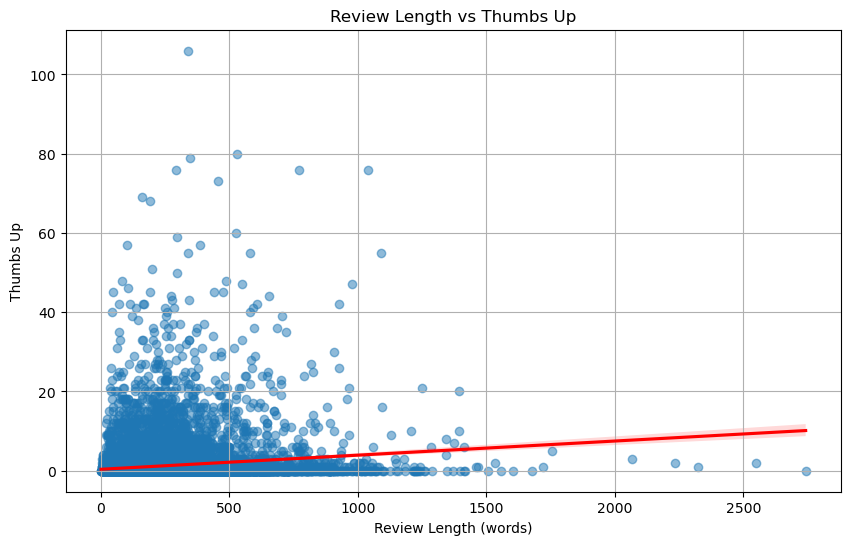

In [31]:
plt.figure(figsize=(10,6))
sns.regplot(x='review_length', y='thumbs_up', data=df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Review Length vs Thumbs Up')
plt.xlabel('Review Length (words)')
plt.ylabel('Thumbs Up')
plt.grid(True)
plt.show()

### Step 15: Fake Review Detection (One-Class SVM)

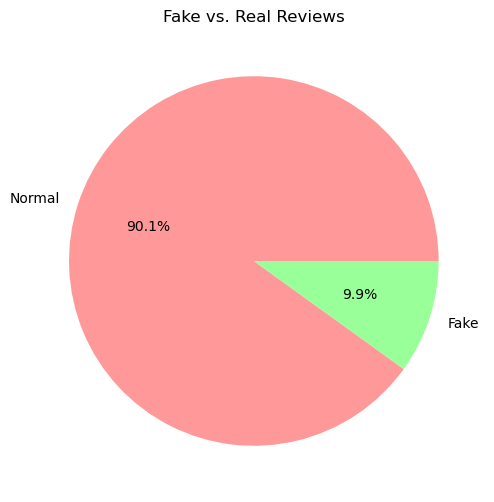

In [33]:
def extract_features(text):
    words = word_tokenize(text)
    if not words:
        return [0, 0, 0]
    avg_word_length = np.mean([len(word) for word in words])
    repeat_words = sum([words.count(w) > 2 for w in set(words)])
    sentiment_score = analyzer.polarity_scores(text)['compound']
    return [avg_word_length, repeat_words, sentiment_score]
df['features'] = df['cleaned_text'].apply(extract_features)
feature_matrix = np.array(df['features'].tolist())
scaler = StandardScaler()
feature_matrix_scaled = scaler.fit_transform(feature_matrix)
oc_svm = OneClassSVM(kernel="rbf", gamma="scale", nu=0.1)
oc_svm.fit(feature_matrix_scaled)
df['review_type'] = oc_svm.predict(feature_matrix_scaled)
df['review_type'] = df['review_type'].apply(lambda x: 'Normal' if x == 1 else 'Fake')
plt.figure(figsize=(6,6))
df['review_type'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['#FF9999', '#99FF99'])
plt.title("Fake vs. Real Reviews")
plt.ylabel("")
plt.show()

### Step 16: Sentiment Distribution in Real vs Fake Reviews

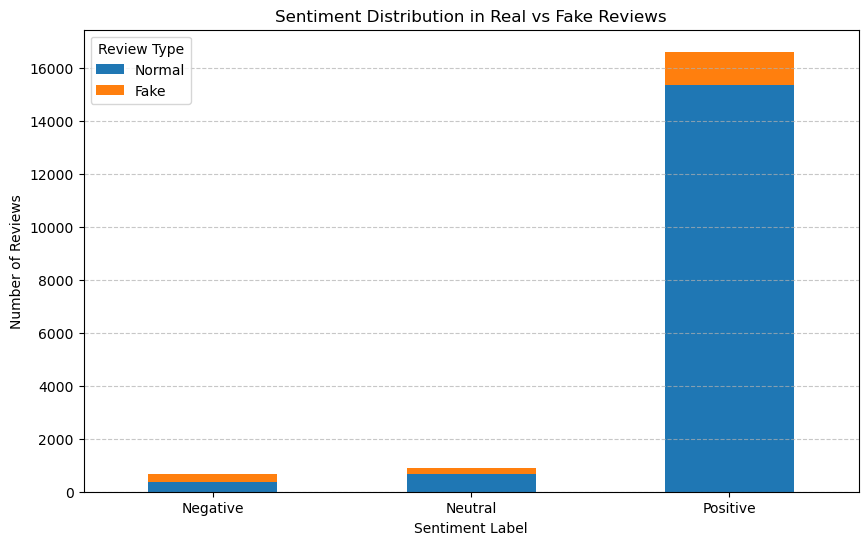

In [35]:
# Visualize the distribution of Sentiment vs Real/Fake Reviews
sentiment_vs_fake = pd.crosstab(df['sentiment_label'], df['review_type'])
sentiment_vs_fake = sentiment_vs_fake[['Normal', 'Fake']]
sentiment_vs_fake.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Sentiment Distribution in Real vs Fake Reviews')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.legend(title='Review Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Step 17: XGBoost Classification with SMOTE for Fake Review Detection


Fake Review Detection Evaluation Metrics (XGBoost after SMOTE):
Accuracy: 99.12 %

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96       539
           1       1.00      0.99      1.00      4909

    accuracy                           0.99      5448
   macro avg       0.97      0.98      0.98      5448
weighted avg       0.99      0.99      0.99      5448


Confusion Matrix:
 [[ 523   16]
 [  32 4877]]


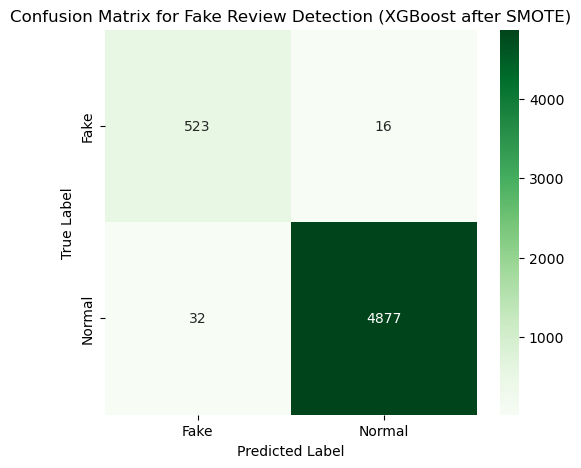

In [37]:
from xgboost import XGBClassifier
# Encoded review type properly: 'Normal' -> 1, 'Fake' -> 0
df['review_label'] = df['review_type'].apply(lambda x: 1 if x == 'Normal' else 0)
#Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature_matrix, df['review_label'], test_size=0.3, random_state=42)
#Balance the training set using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
# Train XGBoost Classifier on balanced data
xgb_classifier = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_classifier.fit(X_train_balanced, y_train_balanced)
# Predict on original test set
y_pred = xgb_classifier.predict(X_test)
#  Evaluate the model
print("\nFake Review Detection Evaluation Metrics (XGBoost after SMOTE):")
print("Accuracy:", round(accuracy_score(y_test, y_pred)*100, 2), "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
#  Plot Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Fake', 'Normal'], yticklabels=['Fake', 'Normal'])
plt.title('Confusion Matrix for Fake Review Detection (XGBoost after SMOTE)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Step 18: WordCloud for Real Reviews and Export Processed Data

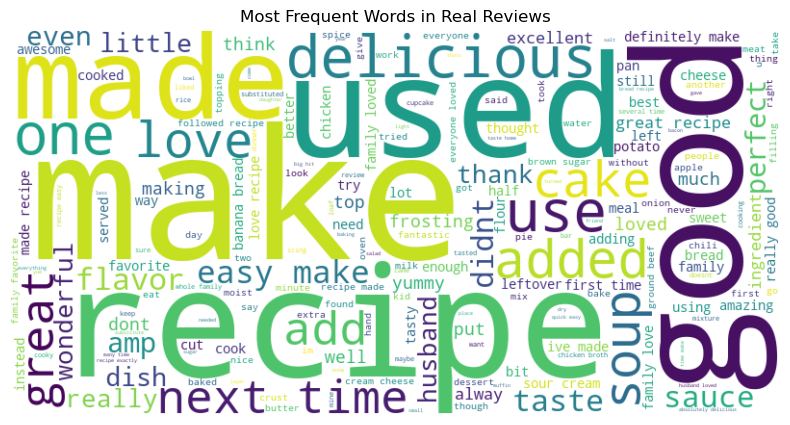

Processed data saved successfully.


In [39]:
# Generate a WordCloud for Real Reviews only
real_reviews_text = ' '.join(df[df['review_type'] == 'Normal']['cleaned_text'])
if real_reviews_text:
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(real_reviews_text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Most Frequent Words in Real Reviews")
    plt.show()
# Save the processed dataframe to a CSV file
df.to_csv("C:/Users/ABHIRAM/Downloads/processed_file.csv", index=False)
print("Processed data saved successfully.")

### 6. Summary 

In [41]:
print("\nSummary:")
print("- Positive reviews are the majority.")
print("- Topics mostly focus on taste, prep time, substitutions.")
print("- About", round((df['review_type'].value_counts(normalize=True)['Fake'])*100, 2), "% of reviews flagged as potentially fake.")


Summary:
- Positive reviews are the majority.
- Topics mostly focus on taste, prep time, substitutions.
- About 9.94 % of reviews flagged as potentially fake.


### 7. Conclusion

The project effectively combines sentiment analysis, topic modeling, and fake review detection to analyze recipe reviews. It provides meaningful insights into user preferences and identifies anomalous reviews, improving the trustworthiness of online feedback.
